<a href="https://colab.research.google.com/github/yueliyl/viprs-tut/blob/main/height_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting VIPRS Model on GWAS data for Standing Height from the UK Biobank

This example illustrate how to fit the `VIPRS` model on external GWAS summary statistics
from the `fastGWA` catalog. The `fastGWA` catalog is a comprehensive GWAS resource on
thousands of phenotypes from the UK Biobank. In this example, we will walk the user
through 4 important steps in fitting PRS models to publicly available GWAS summary data:

1. **Data pre-processing**: Download the GWAS summary statistics for height and **match** them to genotype data for European samples from the 1000G project. The genotype data is restricted to about 15,000 variants on chromosome 22 for now.

2. **Compute LD matrices**: After the GWAS data is downloaded and harmonized with the genotype data, we will compute Linkage-Disequilibrium (LD) matrices that will be used in model fitting. In most applications, it suffices to use publicly available LD matrices, but this example will illustrate how to compute these matrices from genotype data.

3. **Model fit**: After the data is preprocessed and we have the LD matrices computed, we will fit the `VIPRS` model to the data. This will result in a set of inferred effect sizes for each of the 15,000 variants.

4. **Prediction**: After the model is fit, we will predict (sometimes called scoring or linear scoring) height for the 1000G samples. Unfortunately, we don't have real phenotypes for those samples, so we can't evaluate accuracy, but we can inspect the distribution of polygenic scores, etc.

But first things first, let's install and import the needed packages to run this analysis:

In [2]:
import warnings
warnings.filterwarnings("ignore") # ignore warnings

!pip install magenpy>=0.1.1 matplotlib scikit-learn
!pip install --quiet pandas==2.2.1
!pip install --quiet git+https://github.com/yueliyl/viprs # ignore pandas error
!pip install xarray==2023.10.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
os._exit(0) # restart colab kernel to load the installed magenpy

In [1]:
import numpy as np
import magenpy as mgp
import viprs as vp
import matplotlib.pyplot as plt

## 1) Data pre-processing & harmonization

First, let's load and harmonize the data using `magenpy`:

In [2]:
# GWAS summary statistics for Standing Height from fastGWA:
sumstats_url = "https://yanglab.westlake.edu.cn/data/fastgwa_data/UKB/50.v1.1.fastGWA.gz"

# Load genotype data for European samples in the 1000G project (chromosome 22):
gdl = mgp.GWADataLoader(bed_files=mgp.tgp_eur_data_path(),
                        sumstats_files=sumstats_url,
                        sumstats_format="fastGWA")

> Reading genotype metadata...
> Reading summary statistics...


Harmonizing data: 100%|██████████| 22/22 [00:06<00:00,  3.26it/s]


## 2) Computing LD matrices:

Then, we use `magenpy` to compute the reference LD matrices:

In [3]:
# Compute LD using the shrinkage estimator (Wen and Stephens 2010):
gdl.compute_ld("shrinkage",
               output_dir="~/temp",  # Output directory where the LD matrix will be stored
               genetic_map_ne=11400, # effective population size (Ne)
               genetic_map_sample_size=183,
               threshold=1e-3)

> Computing LD matrix...


## 3) Model fit

Next, we fit the `VIPRS` to the harmonized GWAS summary statistics data. Note that the fit will mainly be done on the variants on chromosome 22:

In [4]:
# Fit VIPRS to the summary statistics:
v = vp.VIPRS(gdl).fit()

Chromosome 22 (15935 variants):   0%|          | 0/1000 [00:00<?, ?it/s]

To verify that the model fit behaved as expected with no issues, we can inspect
the objective (Evidence Lower BOund or `ELBO`) as a function of the number of iterations. `viprs` provides a
convenience function to generate this plot:

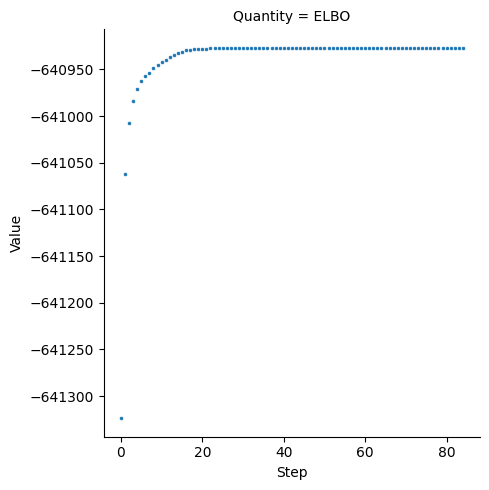

In [5]:
from viprs.plot.diagnostics import plot_history

plot_history(v)

Now that the model converged, we can inspect its estimates of both the global hyperparameters as well as summaries of the posterior distribution for the effect sizes of individual variants.

To obtain the estimates for some of the global hyperparameters, such as heritability, residual variance, proportion of causal variants, etc., we can simply invoke the method `.to_theta_table`:

In [6]:
v.to_theta_table()

,Parameter,Value
0,Residual_variance,9.942213e-01
1,Heritability,5.778935e-03
2,Proportion_causal,1.492955e-02
3,Average_effect_variance,3.411069e-07
4,tau_beta,4.376796e+04


**NOTE:** `VIPRS` is not a method used to estimate heritability or polygenicity (proportion of causal variants). However,
we can obtain estimates for these quantities as part of the model fit.
    
As for summaries of the posterior distribution, one thing we can look at is the
**P**osterior **I**nclusion **P**robability (**PIP**), which is a metric that summarizes
the probability that the variant of interest is causal for the phenotype of interest (e.g. Standing Height):

Text(0.5, 1.0, 'Posterior Inclusion Probability for Standing Height')

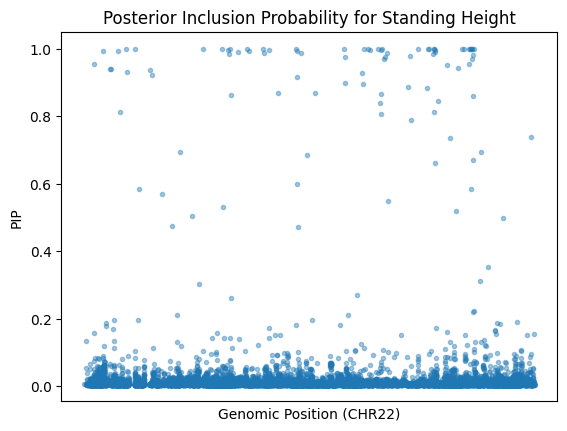

In [7]:
# Get the inferred effect sizes:
effect_table = v.to_table(col_subset=('CHR', 'SNP', 'POS', 'A1', 'A2'))

# Plot the PIP as a function of genomic position:

plt.scatter(effect_table['POS'], effect_table['PIP'],
            alpha=.4, marker='.')
plt.xticks([])
plt.xlabel("Genomic Position (CHR22)")
plt.ylabel("PIP")
plt.title("Posterior Inclusion Probability for Standing Height")

We see from this that most variants have very small probability of meaningfully contributing to Standing Height.
Another illustrative thing that we can do is compare the posterior mean for the effect sizes obtained by `VIPRS`
and compare it to the marginal effect sizes obtained from GWAS:

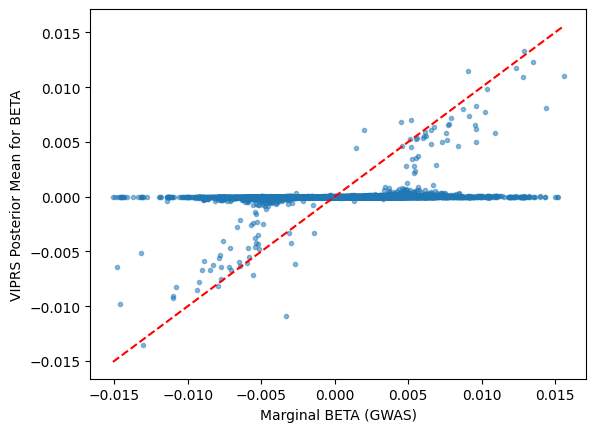

In [8]:
# Get the summary statistics table:
# NOTE: For the purposes of comparing effects on the same scale,
# here, we get standardized BETAs, which is why VIPRS uses for inference:
sumstats = gdl.to_summary_statistics_table(col_subset=('CHR', 'SNP', 'POS', 'A1', 'A2', 'STD_BETA'))

# Rename the BETAs for clarity:
sumstats.rename(columns={'STD_BETA': 'GWAS_BETA'}, inplace=True)
effect_table.rename(columns={'BETA': 'VIPRS_BETA'}, inplace=True)

# Merge the two tables:
merged_table = sumstats.merge(effect_table)

# Plot the results:
plt.scatter(merged_table['GWAS_BETA'],
            merged_table['VIPRS_BETA'],
            alpha=.5,
            marker='.')
plt.xlabel("Marginal BETA (GWAS)")
plt.ylabel("VIPRS Posterior Mean for BETA")

# Plot the unity line to highlight differences in magnitude:
x = np.linspace(merged_table[['GWAS_BETA', 'VIPRS_BETA']].min().min(),
                merged_table[['GWAS_BETA', 'VIPRS_BETA']].max().max(), 100)
plt.plot(x, x, c='red', ls='--')

This plot is a nice illustration of the **selective shrinkage** effect that results
from using sparse Bayesian priors, like the **Spike-and-Slab prior** employed by `VIPRS`. Here, the effects
for most variants are shrunk towards zero, whereas the few variants that are strongly associated
with the phenotype retain their effects.

## 4) Prediction / Generating polygenic scores

Once convergence is achieved, we are going to predict (i.e. compute polygenic scores) on the European samples in the 1000G data. We do not have the observed height for the 1000G data so we cannot assess R-squared. Instead, we can visualize the distribution of the predicted standardized phenotype scores.

> Generating polygenic scores...


Text(0.5, 1.0, 'Height PGS in 1000G (EUR)')

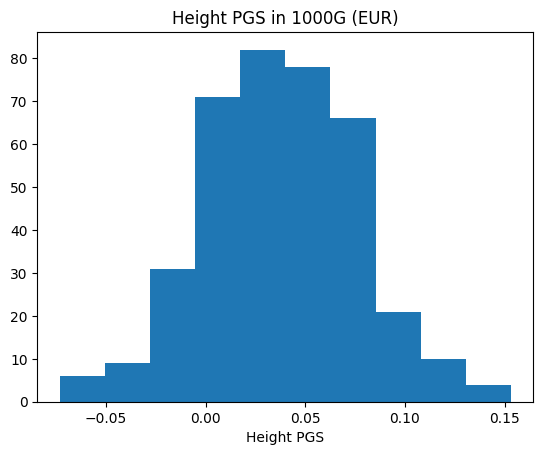

In [9]:
# Obtain height PGS estimates for the European samples in 1000G Project:
height_pgs = v.predict()

# plot distribution of height PGS:

plt.hist(height_pgs)
plt.xlabel("Height PGS")
plt.title("Height PGS in 1000G (EUR)")